### 문제 7-1 : LangGraph ReAct Agent 실습 연습문제 (Vector DB + Tool 연동) 

In [47]:
from dotenv import load_dotenv
load_dotenv()

True

In [48]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [49]:
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

embedding_model = OllamaEmbeddings(model="bge-m3:latest")
menu_db = FAISS.load_local("../db/menu_db", embedding_model, allow_dangerous_deserialization=True)

@tool
def search_cafe_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [59]:
from langgraph.graph import MessagesState
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

class AgentState(MessagesState):
    pass

llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

prompt = ChatPromptTemplate.from_messages([
    ("system", dedent("""
        당신은 카페 메뉴 전문 AI입니다.
        아래 사용자 질문에 대해 직접 답하거나 필요한 경우 도구를 사용해 정보를 검색하세요.
        가능한 경우 'search_cafe_menu' 도구를 사용하세요.
    """)),
    ("placeholder", "{messages}"),
])

agent_runnable = prompt | llm

agent_node = RunnableLambda(
    lambda state: {
        "messages": state["messages"] + [agent_runnable.invoke(state)]
    }
)

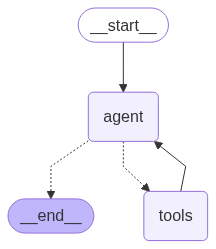

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

builder = StateGraph(AgentState)
builder.add_node("agent", agent_node)
builder.add_node("tools", tool_node)

builder.add_edge(START, "agent")  
builder.add_conditional_edges("agent", tools_condition)
builder.add_edge("tools", "agent")
builder.add_edge("agent", END)   

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [56]:
inputs = [
    "아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.",
    "라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?",
    "디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요."
]

for i in inputs:
    inputs = {"messages": [HumanMessage(content=i)]}
    messages = graph.invoke(inputs)

    for m in messages["messages"]:
        m.pretty_print()


================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
================================== Ai Message ==================================

아메리카노와 아이스 아메리카노의 차이점은 주로 온도와 제공 방식에 있습니다.

1. **아메리카노**: 뜨거운 물에 에스프레소를 섞은 음료로, 보통 따뜻한 상태로 제공됩니다. 이를 통해 부드러운 커피 맛을 느낄 수 있습니다.

2. **아이스 아메리카노**: 에스프레소에 차가운 물과 얼음을 추가하여 만든 음료입니다. 더운 날씨에 시원하게 즐길 수 있는 옵션입니다.

가격은 카페마다 다르지만, 일반적으로 아메리카노와 아이스 아메리카노의 가격 차이는 크지 않습니다. 보통 3,000원에서 5,000원 사이에 판매되며, 지역이나 카페의 고유 특성에 따라 다를 수 있습니다. 구체적인 가격 정보가 필요하다면 특정 카페를 알려주시면 더욱 정확한 정보를 제공할 수 있습니다.
================================ Human Message =================================

라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?
================================== Ai Message ==================================

라떼는 에스프레소와 스팀 밀크, 밀크 폼이 조화를 이루는 음료로, 다양한 변형이 있습니다. 대표적인 라떼 종류와 각각의 특징은 다음과 같습니다:

1. **카페 라떼 (Café Latte)**:
   - 에스프레소와 스팀 밀크를 비율로 섞은 음료입니다. 일반적으로 에스프레소 1샷에 대해 스팀 밀크가 3배 정도 들어가고, 그 위에 밀크 폼이 소량 얹혀집니다.
   - 부드럽고 크리미한 맛이 특징입니다.

2. 